# HashComb testing notebook

## **<span style="color:lime">First section</span>: *basic operations***
| *Cells* | *Content* |
|---|---|
| 1.1 *Tree definition* | How to build a configuration HC Tree and initialize Encoder and Decoder |
| 1.2 *Config file reader* | Visualizer for any configuration `.pkl` files, it shows a tabular version of the tree and a visual results <br>*for any bin in the tree is shown the hash, the min value, the center and the max value* |
| 1.3 *Single value testing* | Defining some test values, perform encode-decode to see the tree quantization effect |
| 1.4 *List value testing* | Defining an array of values, perform encode-decode to see the tree quantization and operation over arrays <br>*shows how the library can be used both with single values and arrays* |
| 1.5 *Tree viewer testing* | Useful to understand how HashComb works over some testing values, showing the tree <br>*every test value is shown over the quantization line, showing in which bin is and the distance from the center* <br>*the tree is shown as a reverse binary tree, with each value, the path for a single focus value is remarked* |

## **<span style="color:lime">Second Section</span>: *Mean example - implementation***
| *Cells* | *Content* |
|---|---|
| 2.1 *Initialization* | Value initialize by generating samples over random distribution and an HashComb instance for the operations |
| 2.2 *Quantization effect* | Mean value over the plaintext and the Enc/Dec values, to measure the quantization error, as a reference <br>*the error is measured by encoding each value and decoding the center of the bin, then calculating the mean over the centers* |
| 2.3 *HashComb mean* | Mean value over the ciphertext, counting the number of occurrences for each hash value (each center) <br>*the expected value is the same as in section 2.2, with same error* <br>*the hash distribution is plotted in reference with the plaintext bin distribution* | 

## **<span style="color:lime">Third Section</span>: *K-Means example - implementation***
| *Cells* | *Content* |
|---|---|
| 3.1 *Initialization* | Value initialize by generating blobs in a 2D space and two HashComb instance for the operations, one for axes |
| 3.2 *Clustering reference* | K-Mean applied over the plaintext blobs, calculating the center position, as references |
| 3.3 *HashComb clustering* | K-Mean applied to the HashComb ciphertext, calculating the centroids weighing the bins in a 2D space <br>*The space is normalized and divided over one dimension, each axe is encoded with single HashComb instance* <br>*Coordinates are decoded just for visualization process, comparing the result with previous centroids* <br> *the Euclidean distance from the plaintext centroids and the HashComb centroids is the quantization error* |
| 3.4 *HashComb K-voting* | Visualizing the voting system in a quantization technique over the values <br>*dividing the space with a bins' check board, voting each 2D-bin counting the occurrences of each hash value* |


#### **<span style="color:purple">Interactions</span>** 
This notebook aims to show the basic functioning of the library HashComb, including some example for real life scenarios  

In each section a cell is reserved to build useful function to not shadow the main functionality and keeping the code clean, trying to explain as best as possible the core functionality of the library 

Each cell is interactive, and it is possible to change some values to see the functionality of the library, especially is interesting changing the "channels" value,  
increasing or decreasing the quantization via adding or removing layer to the binary tree,  
the effect of this alteration can be valued by oscillation of the quantization error in various scenarios, especially in the Mean value and in the centroids in K-mean

#### **<span style="color:purple">CLI wrapper</span>** 

The HashComb library also is CLI wrapped, and can be executed via command line, calling encode and decode functionality, for testing purpose:  
- `python -m src.cli encode --channels <int> --min <float> --max <float> [--config <file.pkl>] --value <float>`
- `python -m src.cli decode [--config <file.pkl>] --hash <str>`



In [27]:
#CLI wrapper cmd usage examples:
! python -m hashcomb.cli encode -help 
print()
print( "EXAMPLE USAGE OVER VALUES: channels=4, min=0.0, max=15.0, config=configuration.pkl value=12.34" )
! python -m hashcomb.cli encode --channels 4 --min 0.0 --max 15.0 --config configuration.pkl --value 12.34
#expected value: 259281614
print()
! python -m hashcomb.cli decode -help
print()
print( "EXAMPLE USAGE OVER VALUES: config=configuration.pkl hash=259281614" )
! python -m hashcomb.cli decode --config configuration.pkl --hash $259281614
#expected value: approximately 12.34

usage: hashcomb encode [-h] --channels CHANNELS --min MIN --max MAX
                       [--config CONFIG] --value VALUE

options:
  -h, --help           show this help message and exit
  --channels CHANNELS  Number of channels of the tree
  --min MIN            Minimum value to encode
  --max MAX            Maximum value to encode
  --config CONFIG      Path to save the configuration file
  --value VALUE        Plaintext value to encode

EXAMPLE USAGE OVER VALUES: channels=4, min=0.0, max=15.0, config=configuration.pkl value=12.34
259281614

usage: hashcomb decode [-h] [--config CONFIG] --hash HASH

options:
  -h, --help       show this help message and exit
  --config CONFIG  Path to load the configuration file
  --hash HASH      Ciphertext value to decode

EXAMPLE USAGE OVER VALUES: config=configuration.pkl hash=259281614
12.65625


##### **<span style="color:purple">Libraries import</span>** 

In [28]:
import sys, os
from pathlib import Path
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px      
import plotly.graph_objects as go 
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from skimage.io import imread
from skimage.color import rgb2gray, rgb2luv, luv2rgb
from skimage import img_as_float, img_as_ubyte
from scipy.spatial.distance import cdist
import numpy as np
import math

from hashcomb.encoder import Encoder
from hashcomb.decoder import Decoder
from hashcomb.tree import Tree
from hashcomb.node import Node
from hashcomb.io import CsvIO, PklIO

## **<span style="color:lime">First Section</span>: *basic operations***

### 1.1 *Tree definition*  
For the HashComb library we must define:  
*channels* $\:\:\:\to$ The number of layer in the tree ($2^{\text{channels}}$ leaves)  
*minVal* $\:\:\:\:\:\:\to$ The smallest value that can be mapped in the tree  
*maxVal* $\:\:\:\:\:\to$ The largest value that can be mapped in the tree  
*configPath* $\to$ Where to store the Tree configuration created by the Encoder  

In [29]:
channels: int = 4
minVal: float = 0.0
maxVal: float = 15.0
configPath = "configuration.pkl"

encoder = Encoder(channels, maxVal, minVal, configPath)
decoder = Decoder(configPath)
print("Tree created with ", len(encoder.hashMap), " leaves")

Tree created with  16  leaves


In [30]:

t = Tree(channels, maxVal, minVal)

def collect_leaves(root: Node):
    leaves = []
    def rec(n: Node):
        if n is None: return
        if n.isLeaf:
            leaves.append(n)
        else:
            rec(n.left)
            rec(n.right)
    rec(root)

    leaves.sort(key=lambda n: n.min)
    return leaves

leaves = collect_leaves(t.root)
leaf_width = (maxVal - minVal) / (2**channels)


def plot_leaves_strip(leaves, inputs=None, title=None):
    if title is None:
        title = f"Leaf intervals — {len(leaves)} leaves"

    fig, ax = plt.subplots(figsize=(10, 2.8))
    y = 0.0

    for n in leaves:
        ax.plot([n.min, n.max], [y, y], linewidth=4)
        ax.plot([n.getCenter], [y], marker="o")

    if inputs:
        for v in inputs:
            ax.plot([v], [y], marker="x", markersize=10)
            ax.annotate(f"{v:.3g}", xy=(v, y), xytext=(0,10), textcoords="offset points", ha="center")

    ax.set_yticks([])
    ax.set_xlabel("value")
    ax.set_title(title)
    ax.set_xlim(min(leaves[0].min, min(inputs) if inputs else leaves[0].min),
                max(leaves[-1].max, max(inputs) if inputs else leaves[-1].max))
    fig.tight_layout()
    plt.show()


def path_for_value(root: Node, v: float):
    path = []
    n = root
    while n is not None:
        path.append(n)
        if n.isLeaf:
            break
        c = n.getCenter
        if v < c:
            n = n.left
        else:
            n = n.right
    return path

p = path_for_value(t.root, 12.34)


def nodes_by_level(root: Node):
    levels = []
    def rec(n: Node, depth: int):
        if n is None: return
        if depth == len(levels):
            levels.append([])
        levels[depth].append(n)
        if not n.isLeaf:
            rec(n.left, depth+1)
            rec(n.right, depth+1)
    rec(root, 0)
    return levels

def plot_tree_levels(root: Node, highlight_path=None, title=None):
    lvls = nodes_by_level(root)
    if title is None:
        title = f"Binary tree — depth={len(lvls)-1}"

    coords = {}
    for d, nodes in enumerate(lvls):
        width = len(nodes)
        xs = list(range(width))
        for i, n in enumerate(nodes):
            coords[n] = (i, -d)

    fig, ax = plt.subplots(figsize=(max(8, len(lvls[-1])), len(lvls) + 2))
    for n, (x,y) in coords.items():
        if n.left:  ax.plot([x, coords[n.left][0]],  [y, coords[n.left][1]],  linewidth=1, alpha=0.5)
        if n.right: ax.plot([x, coords[n.right][0]], [y, coords[n.right][1]], linewidth=1, alpha=0.5)

    for n, (x,y) in coords.items():
        ax.plot(x, y, "o", ms=8, color="#666")
        ax.annotate(f"[{n.min:.3g}, {n.max:.3g}]", (x, y), textcoords="offset points", xytext=(0,10), ha="center", fontsize=8)

    if highlight_path:
        xs = [coords[n][0] for n in highlight_path]
        ys = [coords[n][1] for n in highlight_path]
        ax.plot(xs, ys, "-o", color="C3", linewidth=2.5, ms=10)
        ax.plot(xs[-1], ys[-1], "o", ms=14, mfc="none", mec="C3", mew=2.5)

    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlim(-1, len(lvls[-1]))
    ax.invert_yaxis() 
    fig.tight_layout()
    plt.show()

def visualize_config_pkl(configPath: str, show_table: bool = True):
    hmap: dict[str, Node] = PklIO.loadPickle(configPath)
    print(f"load {configPath}, leaf number: {len(hmap)}")

    rows = []
    for h, n in hmap.items():
        rows.append({
            "hash": h,
            "min": n.min,
            "center": n.getCenter,
            "max": n.max,
            "width": n.max - n.min
        })
    df = pd.DataFrame(rows).sort_values("min").reset_index(drop=True)

    if show_table:
        display(df.head(20)) 

    fig, ax = plt.subplots(figsize=(10, 2.8))
    y = 0.0
    for _, r in df.iterrows():
        ax.plot([r["min"], r["max"]], [y, y], linewidth=4)
        ax.plot([r["center"]], [y], marker="o")
    ax.set_yticks([])
    ax.set_xlabel("value")
    ax.set_title(f"Leaf intervals — {len(df)} leaves")
    plt.show()

    return df 

def plotHashDistribution(clientValues, counts, decoder, meanPlain, meanHashServer):
    allValues = np.concatenate([np.asarray(v) for v in clientValues])

    centers = np.array([decoder.decode(h) for h in counts.keys()])
    freqs = np.array(list(counts.values()), dtype=float)
    freqs = freqs / freqs.sum()

    plt.figure(figsize=(8, 4))
    plt.hist(allValues, bins=40, density=True, alpha=0.4, color="gray", label="origianl value")
    plt.bar(centers, height=(freqs / (centers[1]-centers[0])*25), width=(centers[1]-centers[0]),
            alpha=0.5, color="royalblue", label="hash frequencies")

    plt.axvline(meanPlain, color="black", linestyle="--", label=f"meanPlain={meanPlain:.3f}")
    plt.axvline(meanHashServer, color="red", linestyle="-.", label=f"meanHash={meanHashServer:.3f}")

    plt.xlabel("value")
    plt.ylabel("Density / norm. frequency")
    plt.title("original distribution vs quantized (HashComb)")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()

### 1.2 *Config file reader*

load configuration.pkl, leaf number: 16


,hash,min,center,max,width
0,207770464,0.0000,0.46875,0.9375,0.9375
1,114439058,0.9375,1.40625,1.8750,0.9375
2,73768080,1.8750,2.34375,2.8125,0.9375
3,156069733,2.8125,3.28125,3.7500,0.9375
4,132411821,3.7500,4.21875,4.6875,0.9375
5,96097275,4.6875,5.15625,5.6250,0.9375
6,100176437,5.6250,6.09375,6.5625,0.9375
7,238417091,6.5625,7.03125,7.5000,0.9375
8,265726298,7.5000,7.96875,8.4375,0.9375
9,175889790,8.4375,8.90625,9.3750,0.9375


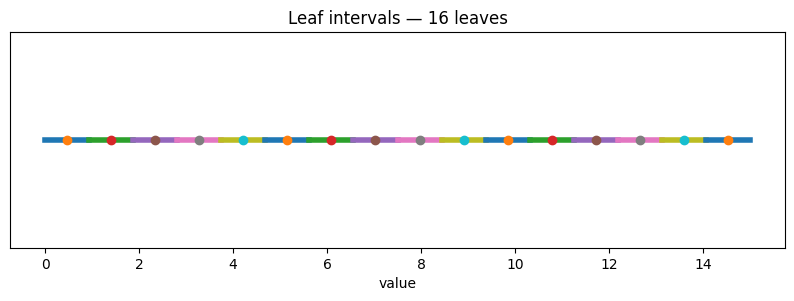

In [31]:
df = visualize_config_pkl("configuration.pkl")

*Definition of some testing values, specifying one focused value for punctual examination*  
The range for each value must be *minVal < value < maxVal*

In [32]:
values = [0.5, 2.3, 2.5, 5.0, 6.2, 7.25, 8,4, 9, 10, 10.1, 12.34, 15]
value = values[4]

### 1.3 *Single value testing*

In [33]:

print("value: ", value)
hashed = encoder.encode(value)
print("hashed value: ", hashed)
decoded = decoder.decode(hashed)
print("decoded value: ", decoded)


value:  6.2
hashed value:  100176437
decoded value:  6.09375


### 1.4 *List value testing*  
Run for reference a for loop over each single value, encoding and decoding individually,  
then run the array functionality encoding and decoding function, showing how the HashComb is MachineLearing-ready (np.array, tensors)

In [34]:
### TEST VALUES AS SINGLE ENCODE DECODE FUNCTION ###
rows =[]
for singlevalue in values:
    hashed = encoder.encode(singlevalue)
    decoded = decoder.decode(hashed)
    rows.append((singlevalue, hashed, decoded))

print(f"{'Value':>8} | {'Hash':>10} | {'Decoded':>10}")
print("-" * 35)
for v, h, d in rows:
    print(f"{v:8.3f} | {h:>10} | {d:10.3f}")


### TEST VALUES WITH ARRAY FUNCTIONALITY ###
print()
print("as a linear array function:")
hashedArray = encoder.encodeArray(values)
decodedArray = decoder.decodeArray(hashedArray)
print("hashed array: " + str(hashedArray))
print("decoded array: " + str(decodedArray))

   Value |       Hash |    Decoded
-----------------------------------
   0.500 |  207770464 |      0.469
   2.300 |   73768080 |      2.344
   2.500 |   73768080 |      2.344
   5.000 |   96097275 |      5.156
   6.200 |  100176437 |      6.094
   7.250 |  238417091 |      7.031
   8.000 |  265726298 |      7.969
   4.000 |  132411821 |      4.219
   9.000 |  175889790 |      8.906
  10.000 |    6681953 |      9.844
  10.100 |    6681953 |      9.844
  12.340 |  259281614 |     12.656
  15.000 |  136526411 |     14.531

as a linear array function:
hashed array: ['207770464' '73768080' '73768080' '96097275' '100176437' '238417091'
 '265726298' '132411821' '175889790' '6681953' '6681953' '259281614'
 '136526411']
decoded array: [ 0.46875  2.34375  2.34375  5.15625  6.09375  7.03125  7.96875  4.21875
  8.90625  9.84375  9.84375 12.65625 14.53125]


### 1.5 *Tree viewer testing*  
For each value in values the is shown by a $\times$ the relative position inside the bin, the quantization effect is the distance between the $\times$ and the center $\bullet$  
For the focused value is shown the binary tree marking the path to the bin where the value is contained

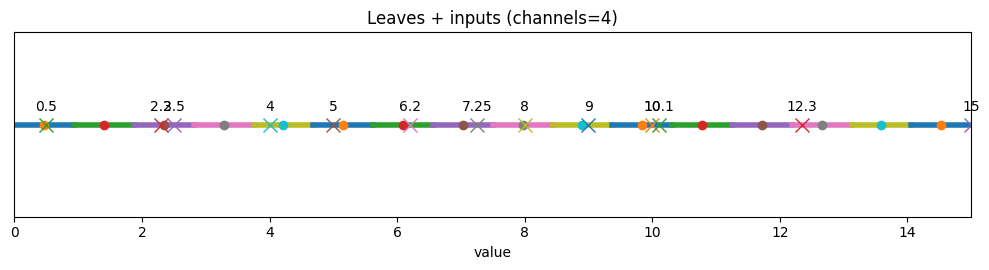

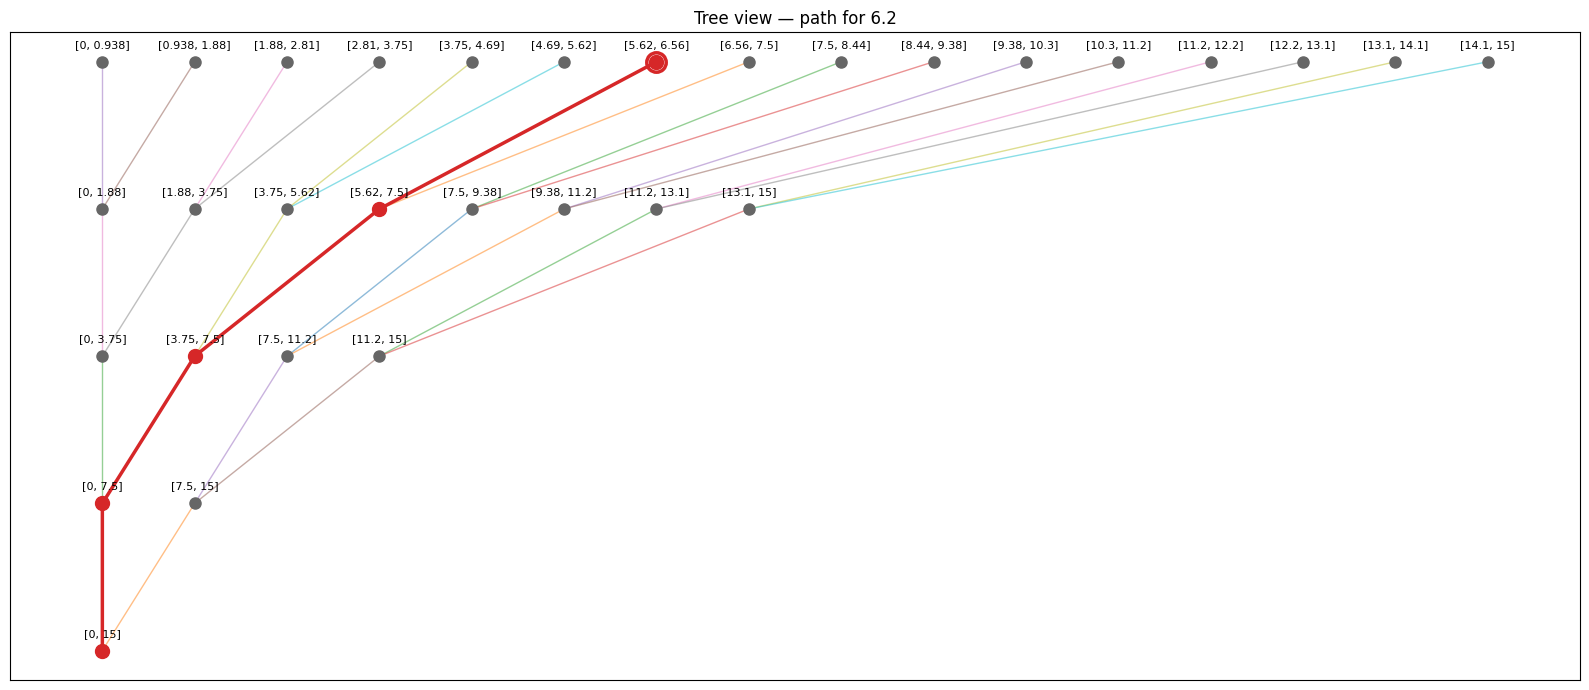

In [35]:
plot_leaves_strip(leaves, inputs=values, title=f"Leaves + inputs (channels={channels})")

plot_tree_levels(t.root, highlight_path=path_for_value(t.root, value),
                 title=f"Tree view — path for {value}")

## **<span style="color:lime">Second Section</span>: *Mean example - implementation***

### 2.1 *Initialization*

In [36]:
np.random.seed(7)

clientValues = [
    np.random.normal(loc= 3, scale=3, size=200).tolist(),
    np.random.normal(loc= 0, scale=2, size=150).tolist(),
    np.random.normal(loc= 2, scale=3, size=100).tolist(),
]

channels: int = 8
minVal: float = -10.0
maxVal: float = 10.0
configPath = "configurationDemo_Mean.pkl"

encoder = Encoder(channels, maxVal, minVal, configPath)
decoder = Decoder(configPath)

print("Tree created with ", len(encoder.hashMap), " leaves")
print ("Random value created ", sum(len(v) for v in clientValues), [len(v) for v in clientValues])

Tree created with  256  leaves
Random value created  450 [200, 150, 100]


In [37]:

def fedavgPlainMeanScalar(clientValues):
    total = sum(np.sum(v) for v in clientValues)
    count = sum(len(v) for v in clientValues)
    return float(total / count)

def fedavgHashcombMeanScalar(clientValues):
    hist = Counter()
    total = 0
    for vals in clientValues:
        encs = encoder.encodeArray(vals)
        hist.update(encs.tolist())
        total += len(encs)

    if total == 0:
        return float("nan")

    sum = 0.0
    for h, c in hist.items():
        decoded = decoder.decode(h)
        sum += decoded * c

    return float(sum / total)

def aggregateHashes(clientValues, encoder):
    counts = Counter()
    totalN = 0
    for vals in clientValues:
        encs = encoder.encodeArray(vals)
        keys = [str(x) for x in encs.tolist()]
        counts.update(keys)
        totalN += len(keys)
    return counts, totalN

def encodedAverage(counts, totalN):
    if totalN == 0:
        return {}
    return {h: c / totalN for h, c in counts.items()}

def meanFromCounts(counts, decoder):
    totalN = sum(counts.values())
    if totalN == 0:
        return float("nan")
    s = 0.0
    for h, c in counts.items():
        center = decoder.decode(h)
        s += center * c
    return float(s / totalN)

### 2.2 *Quantization effect*  
Toy example to measure the quantization effect of the binary tree involved in this operation,  
Each value is mapped inside a bin with a center, the mean is calculated over the number of occurrences of each center  
Plaintext Mean –> the true global average computed from all raw values  
Encoded/Decoded Mean –> each value is quantized and decoded individually using the HashComb encoder/decoder, showing the effect of quantization  

In [38]:
meanPlain = fedavgPlainMeanScalar(clientValues)
meanHash = fedavgHashcombMeanScalar(clientValues)


print("           Some result for reference:     ")
print()
print("Mean of the Plaintext (the reference value):         ", meanPlain)
print("Mean of the HashComb Enc/Dec (expected value):       ", meanHash)



           Some result for reference:     

Mean of the Plaintext (the reference value):          1.6131096381634418
Mean of the HashComb Enc/Dec (expected value):        1.6125


### 2.3 *HashComb mean*   
Toy example to calculate the mean over the ciphertext, counting the hash occurrences:  
Server Aggregated Mean –> clients send only hash codes, the server aggregates identical hashes (without decoding) and later a trusted party reconstructs the mean from hash frequencies  
The test evaluates how close the HashComb-based approximations are to the true mean and visualizes the quantization effect through histogram plots

           Some result from HashComb :     

Mean of the Plaintext:          1.6131096381634418
Mean of the HashComb:           1.6125
Mean of the Server Comb:        1.6125

Absolute Error:                 0.000609638163441728
Relative Error:                 0.00037792729583825034



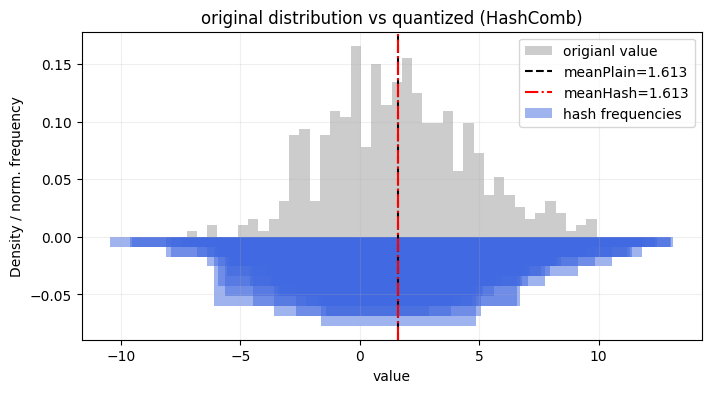

In [39]:
counts, totalN = aggregateHashes(clientValues, encoder)
meanHashServer = meanFromCounts(counts, decoder)

absError = abs(meanPlain - meanHashServer)
relError = absError / max(abs(meanPlain), 1e-6)

print("           Some result from HashComb :     ")
print()
print("Mean of the Plaintext:         ", meanPlain)
print("Mean of the HashComb:          ", meanHash)
print("Mean of the Server Comb:       ", meanHashServer)
print()
print("Absolute Error:                ", absError)
print("Relative Error:                ", relError)
print()
plotHashDistribution(clientValues, counts, decoder, meanPlain, meanHashServer)

## **<span style="color:lime">Third Section</span>: *K-Means example - implementation***

### 3.1 *Initialization*

In [40]:
k = 3
centers = [[1, 2], [-1, -1], [2, -1]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

channels: int = 4
minVal: float = 0.0
maxVal: float = 1.0
configPath = "configuration.pkl"

configX = "configurationDemo_KM_X.pkl"
configY = "configurationDemo_KM_Y.pkl"
encoderX = Encoder(channels, maxVal, minVal, configX)
decoderX = Decoder(configX)
encoderY = Encoder(channels, maxVal, minVal, configY)
decoderY = Decoder(configY)

print("Tree for X created with ", len(encoderX.hashMap), " leaves")
print("Tree for Y created with ", len(encoderY.hashMap), " leaves")
print ( k, "Random blob created " ,X.shape, " with centers in: ", centers)

Tree for X created with  16  leaves
Tree for Y created with  16  leaves
3 Random blob created  (10000, 2)  with centers in:  [[1, 2], [-1, -1], [2, -1]]


In [41]:

def normalizePerAxis(X):
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    rng = np.where((maxs - mins) == 0, 1.0, (maxs - mins))
    return (X - mins) / rng, mins, rng

def denormalizePerAxis(Xn, mins, rng):
    return Xn * rng + mins

def orderedHashes1D(encoder, vmin=0.0, vmax=1.0, samples=20000):
    xs = np.linspace(vmin, vmax, samples)
    hs = encoder.encodeArray(xs) #hash array
    order = []
    last = None
    for h in hs:
        h = str(h)
        if h != last:
            order.append(h)
            last = h
    orderMap = {h:i for i,h in enumerate(order)}
    return order, orderMap

### 3.2 *Clustering reference*  
As in sklearn.cluster references, evaluating KMeans over the plaintext blobs for reference

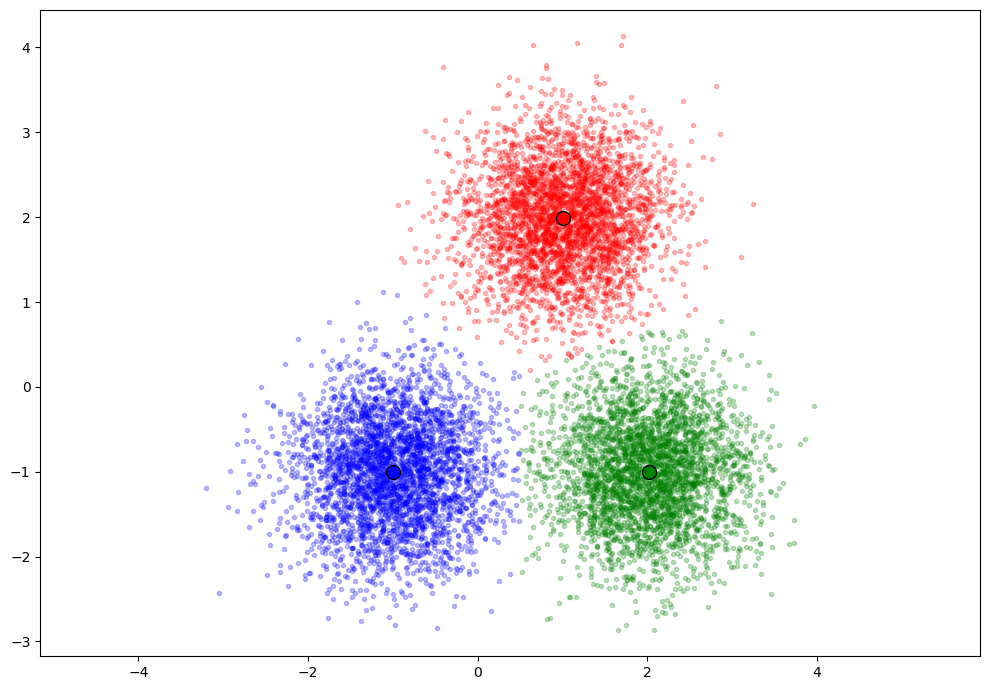

In [42]:
kmeansPlain = KMeans(n_clusters=k, n_init="auto", random_state=0).fit(X)
labelsPlain = kmeansPlain.labels_
centersPlain = kmeansPlain.cluster_centers_

plt.figure(figsize=(10, 7))
colors = cycle('bgrclen(orderY)kbgrclen(orderY)k')
for k_, col in zip(range(k), colors):
    mask = labelsPlain == k_
    c = centersPlain[k_]
    plt.plot(X[mask, 0], X[mask, 1], col + '.', alpha=0.25)
    plt.plot(c[0], c[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=10)
plt.axis('equal'); 
plt.tight_layout(); 
plt.show()

### 3.3 *HashComb clustering*  
This experiment performs K-Means clustering directly on HashComb-encoded values, without ever decoding the original data  
Ciphertext Clustering -> each coordinate is quantized and encoded via HashComb; the ordinal bin index a notion of proximity   
Decoded Visualization -> after clustering in ciphertext space, only the cluster centroids are decoded in plaintext for visualization (and comparison)  
Is calculated the Euclidean distance from the plaintext centroids and the HashComb centroids is the quantization error


center distances (plain <-> ciphertext): [0.21125683 0.12273543 0.18426733]
mean center distance: 0.17275319793667496


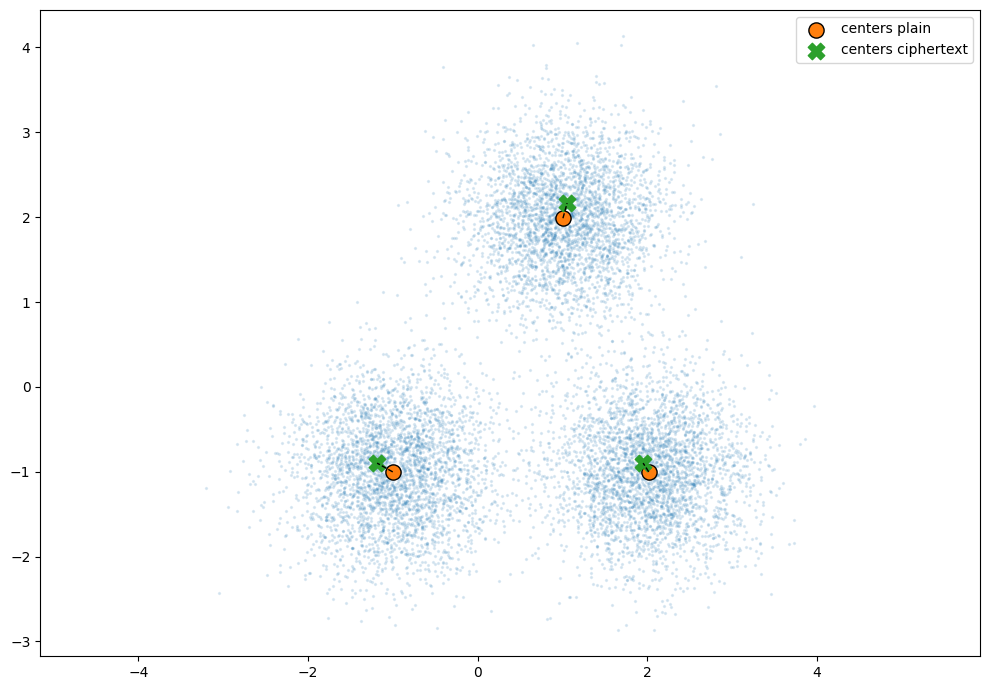

In [43]:
Xn, mins, rng = normalizePerAxis(X)
encX = encoderX.encodeArray(Xn[:,0])
encY = encoderY.encodeArray(Xn[:,1])

# print("Encoded X sample: ", encX)
# print("Encoded Y sample: ", encY)

orderX, orderMapX = orderedHashes1D(encoderX, minVal, maxVal)
orderY, orderMapY = orderedHashes1D(encoderY, minVal, maxVal)

ix = np.array([orderMapX[str(h)] for h in encX], dtype=np.int32)
iy = np.array([orderMapY[str(h)] for h in encY], dtype=np.int32)

pairs = np.column_stack([ix, iy])
keyTuples, inverse, counts = np.unique(pairs, axis=0, return_inverse=True, return_counts=True)

# 3) KMeans over the index (ciphertext) 
kmeansCipher = KMeans(n_clusters=k, n_init="auto", random_state=0)
kmeansCipher.fit(keyTuples, sample_weight=counts)
centersIdx = kmeansCipher.cluster_centers_

centersIdxRound = np.rint(centersIdx).astype(int)
centersIdxRound[:,0] = np.clip(centersIdxRound[:,0], 0, len(orderX)-1)
centersIdxRound[:,1] = np.clip(centersIdxRound[:,1], 0, len(orderY)-1)

# Hash of the blobs centre
centerHashesX = [orderX[i] for i in centersIdxRound[:,0]]
centerHashesY = [orderY[i] for i in centersIdxRound[:,1]]

# 5) decode centers
cx = decoderX.decodeArray(np.array(centerHashesX, dtype=object))
cy = decoderY.decodeArray(np.array(centerHashesY, dtype=object))
centersCipherDecoded01 = np.column_stack([cx, cy]).astype(np.float32)  # in [0,1]

centersCipherDecoded = denormalizePerAxis(centersCipherDecoded01, mins, rng)
centersCipherDecoded

def matchCenters(A, B):
    D = cdist(A, B)
    order = D.argmin(axis=1)
    return B[order], D[np.arange(len(A)), order]

centersCipherMatched, dists = matchCenters(centersPlain, centersCipherDecoded)
print()
print("center distances (plain <-> ciphertext):", dists)
print("mean center distance:", float(dists.mean()))

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], s=2, alpha=0.12)
plt.scatter(centersPlain[:,0], centersPlain[:,1], marker='o', s=120, edgecolor='k', label="centers plain")
plt.scatter(centersCipherMatched[:,0], centersCipherMatched[:,1], marker='X', s=140, label="centers ciphertext")
for a, b in zip(centersPlain, centersCipherMatched):
    plt.plot([a[0], b[0]], [a[1], b[1]], 'k--', linewidth=1)

plt.axis('equal'); 
plt.legend(); 
plt.tight_layout(); 
plt.show()

### 3.4 *HashComb K-voting*
The grid is overlapped with all the points, the color of each square represent how many hashed-values collapse in that 2D bucket (hash center value)  
the grid is normalized with the plaintext values for reference  
increasing the channel value increase the definition of the grid and reduce the quantization error, for both axes

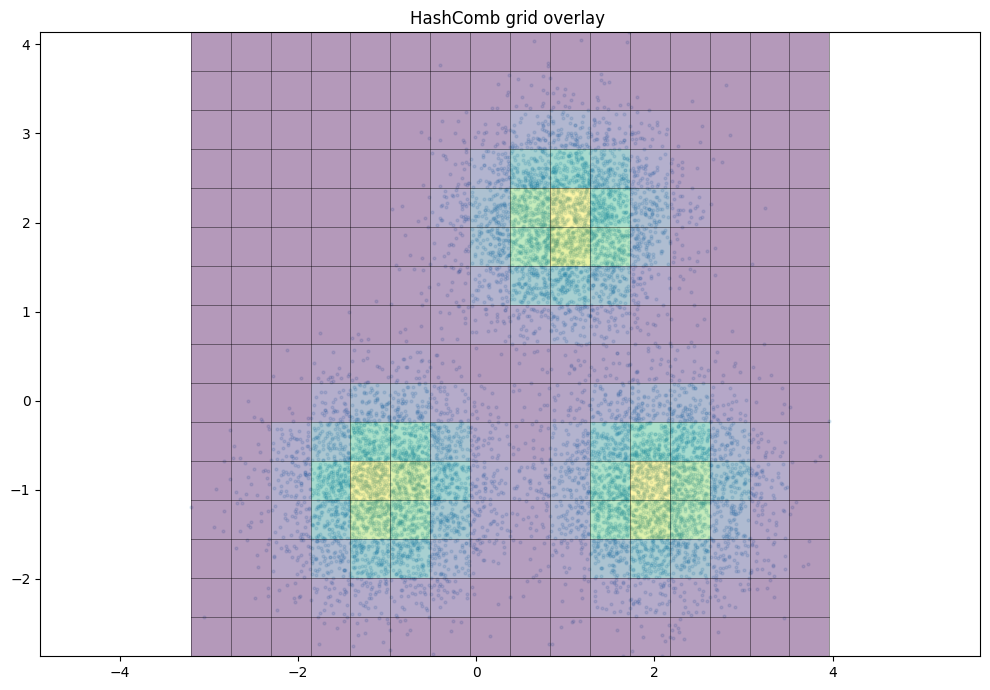

In [44]:
counts = np.zeros((len(orderX), len(orderY)), dtype=np.int32)
np.add.at(counts, (ix, iy), 1)
edgesX01 = np.linspace(0.0, 1.0, len(orderX) + 1)
edgesY01 = np.linspace(0.0, 1.0, len(orderY) + 1)

# 6) mins/rng
ex = edgesX01 * rng[0] + mins[0]
ey = edgesY01 * rng[1] + mins[1]

plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], s=4, alpha=0.15)

# draw bucket lines
for xg in ex:
    plt.plot([xg, xg], [ey[0], ey[-1]], 'k', linewidth=0.6, alpha=0.5)
for yg in ey:
    plt.plot([ex[0], ex[-1]], [yg, yg], 'k', linewidth=0.6, alpha=0.5)

Z = (counts.T / counts.max()).astype(float)         # [len(orderY), len(orderX)]
EX, EY = np.meshgrid(ex, ey, indexing='xy')         # [len(orderY)+1, len(orderX)+1]
plt.pcolormesh(EX, EY, Z, alpha=0.4)

plt.title("HashComb grid overlay ")
plt.axis('equal'); 
plt.tight_layout(); 
plt.show()